In [1]:
import os
import requests

pdf_path = "human-nutrition-text.pdf"

# Download PDF
if not os.path.exists(pdf_path):
    print(f"[INFO] File doesn't exist, downloading..")

    # Enter the URL of the pdf
    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

    # The local filename to save the downloaded file
    filename = pdf_path

    # Send a GET request to the URL
    response = requests.get(url)

    # Check if the request was succesfull
    if response.status_code == 200:
        # Open the files and save it
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"[INFO] The file has been downloaded and saved as {filename}")
    else:
        print(f"[INFO] Failed to download the file. Status code: {response.status_code}")
else:
    print(f"File {pdf_path} exists.")

File human-nutrition-text.pdf exists.


In [2]:
#!pip install PyMuPDF

In [3]:
import fitz
from typing import List, Dict
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    "Performs minor formatting on text."
    cleaned_text = text.replace("\n"," ").strip()

    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> List[Dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        pages_and_texts.append({"page_number": page_number - 41,
                                "page_char_count":len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(".")),
                                "page_token_count":len(text)/4,
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [4]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 834,
  'page_char_count': 1642,
  'page_word_count': 253,
  'page_sentence_count_raw': 25,
  'page_token_count': 410.5,
  'text': 'their infants while taking antiretroviral medications to lower the  risk of transmission.23 In any case, combination feeding (formula  and breastmilk together) is not recommended for mothers who are  HIV positive because the risk of transmitting HIV to the infant is  higher than either breastfeeding or formula feeding alone.  Breastfeeding also is not recommended for women undergoing  radiation or chemotherapy treatment for cancer. Additionally, if an  infant is diagnosed with galactosemia, meaning an inability to  process the simple sugar galactose, the child must be on a  galactose-free diet, which excludes breast milk. This genetic  disorder is a very rare condition, however, and only affects 1 in  thirty- to sixty-thousand newborns.24 When breastfeeding is  contraindicated for any reason, feeding a baby formula enables  parents and care

In [5]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,3,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,3,199.25,Contents Preface University of Hawai‘i at Mā...


In [6]:
df.describe()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00000,1208.000000,1208.000000,1208.000000,1208.000000
mean,562.50000,1148.004139,198.299669,14.180464,287.001035
std,348.86387,560.382275,95.759336,9.544587,140.095569
min,-41.00000,0.000000,1.000000,1.000000,0.000000
25%,260.75000,762.000000,134.000000,8.000000,190.500000
50%,562.50000,1231.500000,214.500000,13.000000,307.875000
75%,864.25000,1603.500000,271.000000,19.000000,400.875000
max,1166.00000,2308.000000,429.000000,82.000000,577.000000


why would we care about token_count?

Toke count is important to think about because:
1. Embedding models dont deal with infinite tokens.
2. LLMS dont deal with infinite tokens

For exmaple an embedding model may have been trained to embed sequences of 384 tokens into numerical space (sentence transformation)
As for LLMs they cant accept infinite tokens in their context window.





# Further text processing- (splitting pages into sentences)
Two ways to do this:
1. We have dne this by splitting on '"."'.
2. We can do this with a NLP library such as spacy and nltk

In [7]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer
nlp.add_pipe(nlp.create_pipe('sentencizer'))

# Create doc isntance as an example
doc = nlp("This is a sentence. this another sentence. I like horses.")
assert len(list(doc.sents)) == 3

list(doc.sents)

[This is a sentence., this another sentence., I like horses.]

In [8]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings (the default type is a datatype)
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [9]:
random.sample(pages_and_texts, k=1)

[{'page_number': 938,
  'page_char_count': 1151,
  'page_word_count': 199,
  'page_sentence_count_raw': 10,
  'page_token_count': 287.75,
  'text': 'Image by  Cosmed /  CC BY-SA  3.0  Muscle Strength  Muscle strength is developed and maintained by weight or  resistance training that often is called anaerobic exercise. Anaerobic  exercise consists of short duration, high intensity movements that  rely on immediately available energy sources and require little or  no oxygen during the activity. This type of high intensity training  is used to build muscle strength by short, high intensity activities.  Building muscle mass is not just crucial for athletes and  bodybuilders—building muscle strength and endurance is important  for children, seniors, and everyone in between. The support that  your muscles provide allows you to work, play, and live more  efficiently. Strength training involves the use of resistance  machines, resistance bands, free weights, or other tools. However,  you do no

In [10]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,14.18,287.00,11.25
std,348.86,560.38,95.76,9.54,140.10,6.50
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,8.00,190.50,6.00
50%,562.50,1231.50,214.50,13.00,307.88,11.00
75%,864.25,1603.50,271.00,19.00,400.88,16.00
max,1166.00,2308.00,429.00,82.00,577.00,33.00


# Chunking our sentences together

The concept of splitting larger pieces of text into smaller ones is referred to as text splitting or chunking

Split inot groups of 10 sentences

Why do we do this?
So our texts are easier to filter
text chunks can fit into our embedding model context window
context passed to an LLM can be more specific and focussed

In [11]:
# Define split size to turn groups of sentences into chunks

num_sentence_chunk_size = 10

# Create a function to split lists of texts recursively into chunk size
# eg [20] -> [10,10] or [25] -> [10,10,5]

def split_list(input_list: List[str],
               slice_size:int=num_sentence_chunk_size) -> List[List[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

test_split = list(range(25))
split_list(test_split)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [12]:
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [13]:
random.sample(pages_and_texts, k=1)

[{'page_number': 44,
  'page_char_count': 607,
  'page_word_count': 114,
  'page_sentence_count_raw': 5,
  'page_token_count': 151.75,
  'text': '(Source:  UNICEF,  1986, How to  weigh and  measure  children:  assessing the  nutrition  status of  young  children)  Biochemical methods of assessing nutritional  status  Biochemical or laboratory methods of assessment include  measuring a nutrient or its metabolite in the blood, feces, urine or  other tissues that have a relationship with the nutrient. An example  of this method would be to take blood samples to measure levels  of glucose in the body. This method is useful for determining if an  individual has diabetes.  Figure 1.4 Measuring Blood Glucose Levels  44  |  Types of Scientific Studies',
  'sentences': ['(Source:',
   ' UNICEF,  1986, How to  weigh and  measure  children:',
   ' assessing the  nutrition  status of  young  children)  Biochemical methods of assessing nutritional  status  Biochemical or laboratory methods of asses

In [14]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,14.18,287.00,11.25,1.59
std,348.86,560.38,95.76,9.54,140.10,6.50,0.67
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,8.00,190.50,6.00,1.00
50%,562.50,1231.50,214.50,13.00,307.88,11.00,2.00
75%,864.25,1603.50,271.00,19.00,400.88,16.00,2.00
max,1166.00,2308.00,429.00,82.00,577.00,33.00,4.00


# Splitting each chunk into its own item

We'd like to embed each chunk of sentences into its own numerical representation.
That will give us a good level of granuality
Meaning we can dive specificaly into the text sample that was used in our model

In [15]:
import re

# split each chunk into its own item

pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join sentences together into a para like structure aka join the list of sentences into one para
        joined_sentence_chunk = "".join(sentence_chunk).replace(" "," ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" ->". A"

        # joined sentence chunk = 
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get some stats on our chunks
        chunk_dict["chunk_chart_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_chart_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)
        

  0%|          | 0/1208 [00:00<?, ?it/s]

1926

In [16]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 334,
  'sentence_chunk': 'to less than 7 percent can further reduce the risk of heart  disease. • Keep the consumption of trans fats (any food label that reads  hydrogenated or partially hydrogenated oil) to a minimum, less  than 1 percent of calories. • Think lean and low-fat when selecting meat, poultry, milk, and  milk products. The current AMDR for child and adolescent fat consumption (for  children over four) are as follows: • For children between ages four and eighteen years, between 25  and 35 percent of caloric intake should be from fat. • For all age groups, most fats should come from  polyunsaturated and monounsaturated fats such as fish, nuts,  and vegetable oils. Identifying Sources of Fat  Population-based studies of American diets have shown that intake  of saturated fat is more excessive than intake of trans fat and  cholesterol. Saturated fat is a prominent source of fat for most  people as it is so easily found in animal fats, tropical oils such as  co

In [17]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_chart_count,chunk_token_count
count,1926.00,1926.00,1926.00
mean,587.02,121.86,179.28
std,348.40,77.16,109.68
min,-41.00,3.00,3.50
25%,283.00,49.00,77.31
50%,592.50,122.00,179.50
75%,893.00,185.00,271.19
max,1166.00,412.00,467.50


# Filter chunks of text for shorter chunks
- These chunks may not contain useeful info

In [18]:
# Show some chunks that have less than 30 tokens

min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 13.5 | Text: Accessed October 5, 2017. Fat-Soluble Vitamins  |  537
Chunk token count: 20.5 | Text: http://www.dashdietoregon.org/. Accessed April 12,  2018. 1050  |  Comparing Diets
Chunk token count: 28.0 | Text: Iron and Iron Deficiency. Centers for Disease Control  and Prevention.http://www.cdc.gov/nutrition/ Iron  |  661
Chunk token count: 28.75 | Text: Fluid  balance refers to maintaining the distribution of water in the body. 386  |  Protein’s Functions in the Body
Chunk token count: 28.5 | Text: In exchange, for the  reabsorption of sodium and water, potassium is excreted. Regulation of Water Balance  |  169


In [19]:
# links and references, overlap sentences

In [20]:
# Filter dataframe for rows under 30 tokens
pages_and_chunks_over_min_token_len = df[df["chunk_chart_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition:2020  Edition  UNIVERSITY OF HAWAI‘I AT MĀNOA  FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM  ALAN TITCHENAL, SKYLAR HARA,  NOEMI ARCEO CAACBAY, WILLIAM  MEINKE-LAU, YA-YUN YANG, MARIE  KAINOA FIALKOWSKI REVILLA,  JENNIFER DRAPER, GEMADY  LANGFELDER, CHERYL GIBBY, CHYNA  NICOLE CHUN, AND ALLISON  CALABRESE',
  'chunk_chart_count': 53,
  'chunk_token_count': 79.75},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition:2020 Edition by University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program is licensed under a Creative Commons Attribution 4.0  International License, except where otherwise noted.',
  'chunk_chart_count': 31,
  'chunk_token_count': 52.75}]

In [21]:
random.sample(pages_and_chunks_over_min_token_len, k =1)

[{'page_number': -32,
  'sentence_chunk': 'The Functions of Carbohydrates in the Body  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  253  Health Consequences and Benefits of High- Carbohydrate Diets  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  260  Carbohydrates and Personal Diet Choices  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  271  Part\xa0V.\xa0Chapter 5. Lipids  Introduction  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  291  The Functions of Lipids in the Body  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  296  The Role of Lipids in Food  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  301  How Lipids Work  University of Hawai‘i at Mānoa Fo

# Embedding our text chunks

Embeddings area broad but powerful concept
they are a learned representation

In [22]:
#pip install -U sentence-transformers

In [23]:
#pip install protobuf==3.19.6


In [24]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",device="cpu")

# Create a list of sentences
sentences = ["The Sentence transformer library provides an easy way to create embeddings",
            "Sentences can be embedded one by one or in a list.",
            "I like horses!"]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences,embeddings))

# see the embeddings
for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embedding}")
    print("")

Sentence: The Sentence transformer library provides an easy way to create embeddings
Embedding: [-3.17512713e-02  3.37267332e-02 -2.52437890e-02  5.22288345e-02
 -2.35249549e-02 -6.19114423e-03  1.35025214e-02 -6.25500977e-02
  7.50832073e-03 -2.29684841e-02  2.98146065e-02  4.57555354e-02
 -3.26700285e-02  1.39847193e-02  4.18013632e-02 -5.92969768e-02
  4.26310301e-02  5.04657347e-03 -2.44552437e-02  3.98591254e-03
  3.55898067e-02  2.78742649e-02  1.84098873e-02  3.67699340e-02
 -2.29961537e-02 -3.01796701e-02  5.99592924e-04 -3.64504047e-02
  5.69104850e-02 -7.49938935e-03 -3.70004512e-02 -3.04365251e-03
  4.64354679e-02  2.36154278e-03  9.06849607e-07  7.00036483e-03
 -3.92289385e-02 -5.95699111e-03  1.38653489e-02  1.87108992e-03
  5.34202717e-02 -6.18613325e-02  2.19613481e-02  4.86051440e-02
 -4.25697304e-02 -1.69858746e-02  5.04178256e-02  1.54733444e-02
  8.12860206e-02  5.07106483e-02 -2.27496885e-02 -4.35720906e-02
 -2.18387460e-03 -2.14091651e-02 -2.01758165e-02  3.0683226

In [25]:
embeddings[0].shape

(768,)

In [26]:
embedding = embedding_model.encode("My favourite animal is the cow!")
embedding

array([-1.45473992e-02,  7.66726658e-02, -2.85872221e-02, -3.31283435e-02,
        3.65210138e-02,  4.78570461e-02, -7.08107948e-02,  1.62833985e-02,
        1.93443652e-02, -2.80482527e-02, -2.91747097e-02,  5.11309505e-02,
       -3.28720361e-02, -8.98756552e-03, -1.03672668e-02, -3.15488726e-02,
        4.22783792e-02, -9.13281552e-03, -1.94017105e-02,  4.35689539e-02,
       -2.31998060e-02,  4.29883339e-02, -1.72393378e-02, -2.01372448e-02,
       -3.13574113e-02,  8.08164291e-03, -2.06725113e-02, -2.27869786e-02,
        2.44812109e-02,  1.71968173e-02, -6.26673177e-02, -7.54797310e-02,
        3.57421711e-02, -5.46573149e-03,  1.24730343e-06, -7.63199804e-03,
       -3.53221893e-02,  1.91326980e-02,  3.99045870e-02,  2.11737677e-03,
        1.64566077e-02,  9.84060578e-03, -1.80700999e-02,  9.33838729e-03,
        3.23482789e-02,  5.84785156e-02,  4.23187427e-02,  1.62091386e-02,
       -9.14911032e-02,  1.82305649e-02, -5.25731221e-03, -7.81020010e-03,
       -3.47644463e-02, -

In [27]:
%%time
embedding_model.to("cuda")

# Embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1632 [00:00<?, ?it/s]

CPU times: total: 2min 51s
Wall time: 32.8 s


In [28]:
%%time

text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
text_chunks[419]

CPU times: total: 0 ns
Wall time: 0 ns


'about their safety. The health concerns of sugar substitutes  originally  stemmed  from  scientific  studies,  which  were  misinterpreted by both scientists and the public. In the early 1970s scientific studies were published that  demonstrated that high doses of saccharin caused bladder tumors  in rats. This information fueled the still-ongoing debate of the  health consequences of all artificial sweeteners. In actuality, the  results from the early studies were completely irrelevant to humans. The large doses (2.5 percent of diet) of saccharine caused a pellet  to form in the rat’s bladder. That pellet chronically irritated the  bladder wall, eventually resulting in tumor development. Since this  study, scientific investigation in rats, monkeys, and humans have  not found any relationship between saccharine consumption and  bladder cancer. In 2000, saccharin was removed from the US  National Toxicology Program’s list of potential carcinogens.1  There have been health concerns over 

In [29]:
len(text_chunks)

1632

In [30]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks, batch_size=32,
                                               convert_to_tensor=True)

text_chunk_embeddings 

CPU times: total: 58.4 s
Wall time: 16 s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.1244,  0.0165, -0.0062,  ..., -0.0390, -0.0407, -0.0136],
        [ 0.0338, -0.0474, -0.0035,  ..., -0.0575, -0.0540, -0.0654],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

# Save embeddings to a file

In [31]:
pages_and_chunks_over_min_token_len[419]

{'page_number': 280,
 'sentence_chunk': 'about their safety. The health concerns of sugar substitutes  originally  stemmed  from  scientific  studies,  which  were  misinterpreted by both scientists and the public. In the early 1970s scientific studies were published that  demonstrated that high doses of saccharin caused bladder tumors  in rats. This information fueled the still-ongoing debate of the  health consequences of all artificial sweeteners. In actuality, the  results from the early studies were completely irrelevant to humans. The large doses (2.5 percent of diet) of saccharine caused a pellet  to form in the rat’s bladder. That pellet chronically irritated the  bladder wall, eventually resulting in tumor development. Since this  study, scientific investigation in rats, monkeys, and humans have  not found any relationship between saccharine consumption and  bladder cancer. In 2000, saccharin was removed from the US  National Toxicology Program’s list of potential carcinogens.

In [32]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path =  "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [33]:
# Import saved file and view
text_chunks_and_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embeddings_df_load.head() 

,page_number,sentence_chunk,chunk_chart_count,chunk_token_count,embedding
0,-39,Human Nutrition:2020 Edition UNIVERSITY OF H...,53,79.75,[ 6.74242675e-02 9.02281255e-02 -5.09547628e-...
1,-38,Human Nutrition:2020 Edition by University of ...,31,52.75,[ 5.52156307e-02 5.92139177e-02 -1.66167337e-...
2,-37,Contents Preface University of Hawai‘i at Mā...,145,199.25,[ 2.79801842e-02 3.39813866e-02 -2.06426550e-...
3,-36,Lifestyles and Nutrition University of Hawai‘...,177,244.00,[ 6.82566985e-02 3.81274670e-02 -8.46855156e-...
4,-35,The Cardiovascular System University of Hawai...,191,259.25,[ 3.30264494e-02 -8.49769637e-03 9.57157742e-...


if embedding daatabses is really(100,000+ embeddings) large use vector database, it uses approximamte nearest neighbor for search

# 2 RAG: Search and Answer

Retrieve relevant passages based on query
input to LLM so that it can generate an output

# Similarity search
Embeddings can be used ofr almost any type of data
For eg, you caan turn images into embeddings, sound into embeddings, text into embeddings, etc..
Comparing embeddings search is known as simlarity search, vector search, semantic search

In this case, we want to query based on textbook passages based on semantics or vibe.
Whereas with keyboard search, if we search apple, we get back passages with specifically apple.


In [34]:
device = "cuda"

In [35]:
import random
import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

#Import texts and embeddings df
text_chunks_and_embeddings_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it saved to csv)
text_chunks_and_embeddings_df['embedding'] = text_chunks_and_embeddings_df['embedding'].apply(lambda x:np.fromstring(x.strip("[]"), sep=" "))

# convert embeddings to torch.sensor
embeddings = torch.tensor(np.stack(text_chunks_and_embeddings_df["embedding"].tolist(),axis=0), dtype=torch.float).to("cuda")

# convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient="records")

text_chunks_and_embeddings_df

,page_number,sentence_chunk,chunk_chart_count,chunk_token_count,embedding
0,-39,Human Nutrition:2020 Edition UNIVERSITY OF H...,53,79.75,"[0.0674242675, 0.0902281255, -0.00509547628, -..."
1,-38,Human Nutrition:2020 Edition by University of ...,31,52.75,"[0.0552156307, 0.0592139177, -0.0166167337, -0..."
2,-37,Contents Preface University of Hawai‘i at Mā...,145,199.25,"[0.0279801842, 0.0339813866, -0.020642655, 0.0..."
3,-36,Lifestyles and Nutrition University of Hawai‘...,177,244.00,"[0.0682566985, 0.038127467, -0.00846855156, -0..."
4,-35,The Cardiovascular System University of Hawai...,191,259.25,"[0.0330264494, -0.00849769637, 0.00957157742, ..."
...,...,...,...,...,...
1627,1164,Liver Biology Medical Anatomy” by LJNovaScoti...,77,128.50,"[0.0186815672, -0.026391238, 0.00842146762, -0..."
1628,1165,ShareAlike 11. Organs reused “Pancreas Organ ...,106,175.25,"[0.0662351921, 0.0102236345, -0.0120226247, 0...."
1629,1165,Protein reused “The Macronutrients:Carbohydrat...,125,202.50,"[0.124367051, 0.0165275782, -0.00623952132, 0...."
1630,1165,Structure of all-trans retinol” by NEUROtiker...,36,54.75,"[0.0337775834, -0.0474043377, -0.00352503126, ..."


In [36]:
embeddings.shape

torch.Size([1632, 768])

In [37]:
text_chunks_and_embeddings_df["embedding"]

0       [0.0674242675, 0.0902281255, -0.00509547628, -...
1       [0.0552156307, 0.0592139177, -0.0166167337, -0...
2       [0.0279801842, 0.0339813866, -0.020642655, 0.0...
3       [0.0682566985, 0.038127467, -0.00846855156, -0...
4       [0.0330264494, -0.00849769637, 0.00957157742, ...
                              ...                        
1627    [0.0186815672, -0.026391238, 0.00842146762, -0...
1628    [0.0662351921, 0.0102236345, -0.0120226247, 0....
1629    [0.124367051, 0.0165275782, -0.00623952132, 0....
1630    [0.0337775834, -0.0474043377, -0.00352503126, ...
1631    [0.0863773897, -0.012535885, -0.0112746796, 0....
Name: embedding, Length: 1632, dtype: object

In [38]:
# embeddings = np.stack(text_chunks_and_embeddings_df["embedding"].tolist(),axis=0)
# embeddings

In [39]:
# Create model

from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                     device="cuda")

# Lets create a small semantic search pipeline
we want to search for a query

we can do it with the following steps:
1. Define a query string
2. Turn the query string into embedding
3. Perform d dot product or cosine similarity function between the text embeddings and the query embedding
4. Sort the results from 3 in descending order



In [40]:
 #Note: To use dot product for comparison, ensure vector sizes are of the same shape and tensor/vectors are in the same data type

In [41]:
# 1. Define the query
query = "macronutrients functions"
print(f"Query: {query}")

# 2. Embed the query
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

# Get Similarity score with the dot product
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"[INFO] TIme taken to get scores on {len(embedding)} embeddings: {end_time-start_time:.5f} seconds.")

# 4 Get top-k results (top 5 here)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrients functions
[INFO] TIme taken to get scores on 768 embeddings: 0.00020 seconds.


torch.return_types.topk(
values=tensor([0.6935, 0.6541, 0.6536, 0.6471, 0.6419], device='cuda:0'),
indices=tensor([42, 40, 52, 48, 49], device='cuda:0'))

In [42]:
pages_and_chunks[42]

{'page_number': 5,
 'sentence_chunk': 'Macronutrients  Nutrients  that  are  needed  in  large  amounts  are  called  macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically  processed into cellular energy. The energy from macronutrients  comes from their chemical bonds. This chemical energy is  converted into cellular energy that is then utilized to perform work,  allowing our bodies to conduct their basic functions. A unit of  measurement of food energy is the calorie. On nutrition food labels  the amount given for “calories” is actually equivalent to each calorie  multiplied by one thousand. A kilocalorie (one thousand calories,  denoted with a small “c”) is synonymous with the “Calorie” (with a  capital “C”) on nutrition food labels. Water is also a macronutrient in  the sense that you require a large amount of it, but unlike the other  macronutrients, it does not yield calories.',
 'chunk_chart_count': 160,
 'chunk

In [43]:
larger_embeddings = torch.randn(100*embeddings.shape[0],768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product acorss 168000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds")                                                                                          

Embeddings shape: torch.Size([163200, 768])
[INFO] Time taken to get scores on 163200 embeddings: 0.00357 seconds


In [44]:
# Searching over embeddings is fast even if we do exhaustive, but if there are millions of embeddings then it is essential to create an index.
# An index is like letters in the dictionary
# For eg if you search for duck, it would begin with d then find words da..db..du.. etc.
# A Popular indexing library is faiss

In [45]:
# Define helper function to print wrapped text 
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [46]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'macronutrients functions'

Results:
Score: 0.6935
Text:
Macronutrients  Nutrients  that  are  needed  in  large  amounts  are  called
macronutrients. There are three classes of macronutrients: carbohydrates,
lipids, and proteins. These can be metabolically  processed into cellular
energy. The energy from macronutrients  comes from their chemical bonds. This
chemical energy is  converted into cellular energy that is then utilized to
perform work,  allowing our bodies to conduct their basic functions. A unit of
measurement of food energy is the calorie. On nutrition food labels  the amount
given for “calories” is actually equivalent to each calorie  multiplied by one
thousand. A kilocalorie (one thousand calories,  denoted with a small “c”) is
synonymous with the “Calorie” (with a  capital “C”) on nutrition food labels.
Water is also a macronutrient in  the sense that you require a large amount of
it, but unlike the other  macronutrients, it does not yield calories.
Page number: 

if we wanted to inspect the result further, we get the page number where the text appears.

How about we check the page to verify?

We can do so by loading the page number containing the highest result (page 5 but really page 5 + 41 since our PDF page numbers start on page 41).

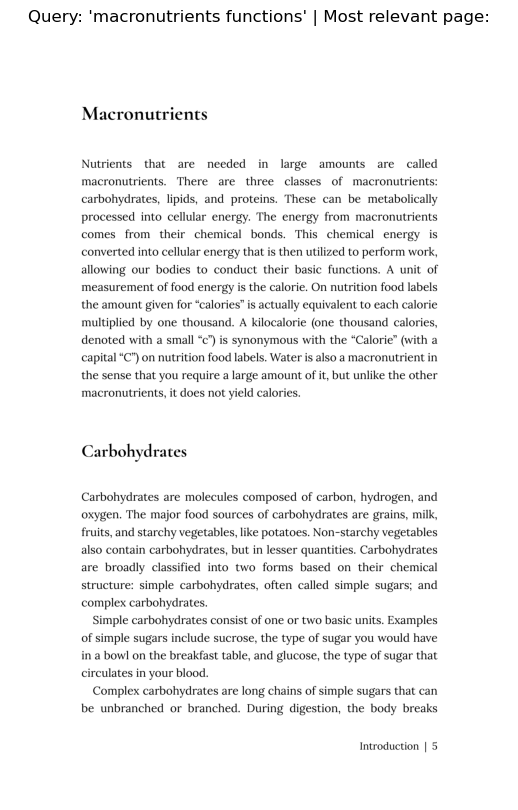

In [47]:
import fitz

# Open PDF and load target page
pdf_path = "human-nutrition-text.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41) # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv, 
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

The workflow is the same:

ingest documents -> split into chunks -> embed chunks -> make a query -> embed the query -> compare query embedding to chunk embeddings

# Similarity measures: dot product and cosine similarity

Let's talk about how we measure similarity between vectors, specifically embedding vectors. These vectors represent data in a high-dimensional space (in our case, they have 768 dimensions) and capture both magnitude and direction.

Two of the most common similarity measures are dot product and cosine similarity. They are very similar, but there is one key difference:

Cosine similarity measures how similar two vectors are based on their direction, ignoring their magnitude.
Dot product considers both magnitude and direction and is generally faster because it does not require normalization.
For text similarity, cosine similarity is usually preferred because it focuses on the meaning (semantic relationships) rather than the size of the vectors.

The all-mpnet-base-v2 embedding model outputs normalized vectors, meaning the dot product and cosine similarity give the same results. Since dot product is faster, it is often the better choice for comparison.on step.

In [48]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Calculate cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


# Functionizing our semantic search pipeline
Let's put all of the steps from above for semantic search into a function or two so we can repeat the workflow.

In [49]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, 
                                   convert_to_tensor=True) 

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, 
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: List[Dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [50]:
query = "symptoms of pellagra"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 1632 embeddings: 0.00007 seconds.


(tensor([0.5000, 0.4112, 0.3106, 0.2959, 0.2826], device='cuda:0'),
 tensor([ 813, 1494,  845, 1490,  272], device='cuda:0'))

In [51]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 1632 embeddings: 0.00009 seconds.
Query: symptoms of pellagra

Results:
Score: 0.5000
Niacin deficiency is commonly known as pellagra and  the symptoms include
fatigue, decreased appetite, and indigestion.  These symptoms are then commonly
followed by the four D’s: diarrhea, dermatitis, dementia, and sometimes death.
Figure 9.12  Conversion of Tryptophan to Niacin  Water-Soluble Vitamins  |  565
Page number: 565


Score: 0.4112
• A tingling mouth  • Swelling tongue and/or throat  • Difficulty breathing  •
Hives  • Stomach cramps  • Diarrhea  • Vomiting  • Drop in blood pressure  •
Loss of consciousness  Nutrition, Health and Disease  |  1081
Page number: 1081


Score: 0.3106
Niacin deficiency, also known as pellagra, was prominent in poorer  Americans
whose main dietary staple was refined cornmeal. Its  symptoms were severe and
included diarrhea, dermatitis, dementia,  and even death. Some of the health
consequences of pellagra are  the result of niac

# Semantic search/vector search extensions
We have seen how to use embedding vector search to find relevant results based on a query.

However, we can also improve this by adding traditional keyword search. Many modern search systems combine both keyword and vector search to get better results.

Right now, our dataset is small, so we can compare the query with every possible result. But when working with large datasets containing hundreds of thousands, millions, or even billions of vectors, searching everything becomes too slow.

To solve this, we use an index, which helps organize embeddings before searching through them.

An index reduces the number of comparisons needed to find a result. For example, if you were looking for the word "duck" in a dictionary, you wouldn't search every word one by one. Instead, you would jump straight to the letter D, then quickly find "duck" among nearby words.

This is how an index speeds up searching without losing too much accuracy. A common approach for this is nearest neighbor search.

One of the most widely used libraries for indexing is Faiss. It is an open-source tool developed by Facebook to handle large-scale vector searches efficiently. It includes advanced algorithms like HNSW (Hierarchical Navigable Small Worlds) to speed up searches.

# Getting an LLM for local generation

In [52]:
from huggingface_hub import login

In [53]:
login()

# Avaliable GPU


In [54]:
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes)/2**30
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 5.99951171875 GB


In [55]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 5.99951171875 | Recommended model: Gemma 2B in 4-bit precision.
use_quantization_config set to: True
model_id set to: google/gemma-2b-it


In [56]:
#pip install -U bitsandbytes

In [57]:
#pip install optimum[onnxruntime-gpu]

In [58]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available
from transformers import BitsAndBytesConfig

# 1. Set the model ID
model_id = "google/gemma-2b"

# 2. Configure 4-bit quantisation for lower VRAM usage
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

# 3. Check if Flash Attention 2 is available (not necessary for RTX 3060 but included)
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
    attn_implementation = "flash_attention_2"
else:
    attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 4. Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

# 5. Load model with optimised settings for RTX 3060 (6GB VRAM)
llm_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    quantization_config=quantization_config,  # Ensure quantisation to fit in 6GB VRAM
    low_cpu_mem_usage=True,  # Reduce CPU memory footprint
    attn_implementation=attn_implementation
)

# 6. Move model to GPU if quantisation is disabled
if not quantization_config:
    llm_model.to("cuda")

print("[INFO] Model loaded successfully and ready for inference.")


[INFO] Using attention implementation: sdpa


tokenizer_config.json:   0%|          | 0.00/33.6k [00:00<?, ?B/s]

C:\Users\PRANAV\.conda\envs\pt_25\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\PRANAV\.cache\huggingface\hub\models--google--gemma-2b. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

[INFO] Model loaded successfully and ready for inference.


In [59]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): G

In [60]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

1515268096

In [61]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 2039641088, 'model_mem_mb': 1945.15, 'model_mem_gb': 1.9}

We can generate text using our LLM model by calling the generate() method. This method takes a tokenized input and allows us to customize the output with different options.

To get a tokenized input, we first pass a text string to the tokenizer.

It is important to use the correct tokenizer that matches the model. If you use a different tokenizer, the model may produce errors or unexpected results.

Some LLMs require a specific input format for the best results. For example, the Gemma-7B-IT model is trained for dialogue (instruction tuning).

For such models, the tokenizer has a method called apply_chat_template(), which formats the input text correctly.

Let's try using it.

In [63]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load tokenizer and model
model_id = "google/gemma-2b"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16, device_map="auto")

# Input text
input_text = "What are the macronutrients, and what roles do they play in the human body?"
print(f"Input text:\n{input_text}")

# Manually format the prompt (since Gemma 2B does not have a chat template)
prompt = f"<start_of_turn>user\n{input_text}<end_of_turn>\n<start_of_turn>model\n"

print(f"\nPrompt (formatted):\n{prompt}")

# Tokenize input
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")

# Generate response
output = model.generate(input_ids, max_new_tokens=100)

# Decode output
response = tokenizer.decode(output[:, input_ids.shape[-1]:][0], skip_special_tokens=True)
print(f"\nModel Response:\n{response}")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


Input text:
What are the macronutrients, and what roles do they play in the human body?

Prompt (formatted):
<start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model



C:\Users\PRANAV\.conda\envs\pt_25\lib\site-packages\transformers\models\gemma\modeling_gemma.py:376: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(



Model Response:
The macronutrients are the three major nutrients that the body needs to function properly. They are carbohydrates, proteins, and fats. Each of these nutrients has a specific role in the body.
sunami
Carbohydrates are the body's main source of energy. They are found in foods such as bread, pasta, rice, and fruits. Proteins are the body's building blocks. They are found in foods such as meat, fish, eggs, and dairy products. Fats are the body's


Notice the scaffolding around our input text, this is the kind of turn-by-turn instruction tuning our model has gone through.

Our next step is to tokenize this formatted text and pass it to our model's generate() method.

We'll make sure our tokenized text is on the same device as our model (GPU) using to("cuda").

Let's generate some text!

We'll time it for fun with the %%time magic.

In [64]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig 
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,    106,   1645,    108,   1841,    708,    573, 186809, 184592,
         235269,    578,   1212,  16065,    749,    984,   1554,    575,    573,
           3515,   2971, 235336,    107,    108,    106,   2516,    108]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]], device='cuda:0')}

Model output (tokens):
tensor([     2,    106,   1645,    108,   1841,    708,    573, 186809, 184592,
        235269,    578,   1212,  16065,    749,    984,   1554,    575,    573,
          3515,   2971, 235336,    107,    108,    106,   2516,    108,    651,
          7667, 136526,    708,    573,   2910, 235269,   5766, 235269,    578,
          7667,  99944,   8329,  19710,    674,    708,   1644,    908,    576,
          1767,   9595,  24582, 235265,    714,   7667, 136526,    708,   1644,
           908,    576,   4374,  95171,   2689, 235269,  9298

Woohoo! We just generated some text on our local GPU!

Well not just yet...

Our LLM accepts tokens in and sends tokens back out.

We can conver the output tokens to text using tokenizer.decode().

In [65]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model
The macromolecules are the large, complex, and macromolecular compounds that are made up of many smaller molecules. The macromolecules are made up of polysaccharids, lipids, and proteins. The polysaccharids are made up of polysaccharids, lipids, and proteins. The polysaccharids are made up of polysaccharids, lipids, and proteins. The polysaccharids are made up of polysaccharids, lipids, and proteins. The polysaccharids are made up of polysaccharids, lipids, and proteins. The polysaccharids are made up of polysaccharids, lipids, and proteins. The polysaccharids are made up of polysaccharids, lipids, and proteins. The polysaccharids are made up of polysaccharids, lipids, and proteins. The polysaccharids are made up of polysaccharids, lipids, and proteins. The polysaccharids are made up of polysaccharids, lipids, and proteins. The p

In [66]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: What are the macronutrients, and what roles do they play in the human body?

Output text:
The macromolecules are the large, complex, and macromolecular compounds that are made up of many smaller molecules. The macromolecules are made up of polysaccharids, lipids, and proteins. The polysaccharids are made up of polysaccharids, lipids, and proteins. The polysaccharids are made up of polysaccharids, lipids, and proteins. The polysaccharids are made up of polysaccharids, lipids, and proteins. The polysaccharids are made up of polysaccharids, lipids, and proteins. The polysaccharids are made up of polysaccharids, lipids, and proteins. The polysaccharids are made up of polysaccharids, lipids, and proteins. The polysaccharids are made up of polysaccharids, lipids, and proteins. The polysaccharids are made up of polysaccharids, lipids, and proteins. The polysaccharids are made up of polysaccharids, lipids, and proteins. The polysaccharids are made up of polysaccharids, lipids, and 

In [67]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions

In [68]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: How do vitamins and minerals differ in their roles and importance for health?
[INFO] Time taken to get scores on 1632 embeddings: 0.00037 seconds.


(tensor([0.6334, 0.6322, 0.6187, 0.6128, 0.6091], device='cuda:0'),
 tensor([ 48,  52, 865, 918,  50], device='cuda:0'))

In essence, we start with a base prompt and update it with context text.

Let's write a function called prompt_formatter that takes in a query and our list of context items (in our case it'll be select indices from our list of dictionaries inside pages_and_chunks) and then formats the query with text from the context items.

In [74]:
def prompt_formatter(query, context_items):
    # Ensure we extract text from dictionaries
    context_text = "\n\n".join(
        item["content"] if isinstance(item, dict) and "content" in item else str(item)
        for item in context_items
    )

    # Manually format the prompt using Gemma's expected structure
    base_prompt = f"""
<start_of_turn>user
Here is some relevant information:\n{context_text}

Now, answer the following query:\n{query}
<end_of_turn>

<start_of_turn>model
"""
    return base_prompt  # Correctly formatted prompt for Gemma



In [75]:
prompt = prompt_formatter(query=query, context_items=context_items)
print(prompt)



<start_of_turn>user
Here is some relevant information:
{'page_number': 1086, 'sentence_chunk': 'Image by  Allison  Calabrese /  CC BY 4.0  fiber intake because of what the breakdown products of the fiber  do for the colon. The bacterial breakdown of fiber in the large  intestine releases short-chain fatty acids. These molecules have  been found to nourish colonic cells, inhibit colonic inflammation,  and stimulate the immune system (thereby providing protection  of the colon from harmful substances). Additionally, the bacterial  indigestible fiber, mostly insoluble, increases stool bulk and softness  increasing transit time in the large intestine and facilitating feces  elimination. One phenomenon of consuming foods high in fiber is  increased gas, since the byproducts of bacterial digestion of fiber  are gases. Figure 18.2 Diverticulitis:A Disease of Fiber Deficiency  Some studies have found a link between high dietary-fiber intake  and a decreased risk for colon cancer. However an a

# Retrieval 

In [85]:
from transformers.utils import TRANSFORMERS_CACHE
import os

print(f"Your Hugging Face Cache Directory: {TRANSFORMERS_CACHE}")
print("Subdirectories inside cache:")
print(os.listdir(TRANSFORMERS_CACHE))


Your Hugging Face Cache Directory: C:\Users\PRANAV\.cache\huggingface\hub
Subdirectories inside cache:
['.locks', 'models--bert-base-uncased', 'models--google--gemma-2b', 'models--google--gemma-2b-it', 'models--microsoft--deberta-v3-small', 'models--sentence-transformers--all-mpnet-base-v2', 'version.txt']


In [86]:
import os

model_base_path = "C:/Users/PRANAV/.cache/huggingface/hub/models--google--gemma-2b"
snapshots_path = os.path.join(model_base_path, "snapshots")

if os.path.exists(snapshots_path):
    print("Available snapshots:")
    print(os.listdir(snapshots_path))  # List snapshot folders
else:
    print("No snapshots found. The model might be incomplete or stored elsewhere.")

Available snapshots:
['9cf48e52b224239de00d483ec8eb84fb8d0f3a3a']


# Augmentation

In [97]:
#  Free up unused memory before running generation
torch.cuda.empty_cache()
torch.cuda.memory_summary(device="cuda")

#  Tokenize Input (Ensure proper tokenization)
input_data = tokenizer(prompt, return_tensors="pt")
input_ids = input_data.input_ids.to("cuda")
attention_mask = input_data.attention_mask.to("cuda")  # Fix for missing attention mask

#  Generate Response with Optimised Memory Usage
with torch.inference_mode():
    outputs = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,  #  Fix: Explicitly pass attention mask
        temperature=0.7,  # Controls randomness
        do_sample=True,  # Enable sampling for creativity
        max_new_tokens=128,  # Prevents VRAM overflow, ensures full response
        pad_token_id=tokenizer.eos_token_id  # Fixes padding issues
    )

#  Decode Output
output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

#  Format the response to match expected output
if "**Relevant passages:**" not in output_text:
    output_text = f"**Relevant passages:**\n\n{context_items[0]['sentence_chunk']}\n\n**Answer:**\n{output_text.strip()}"

#  Display the Result
print(f"\nQuery: {query}")
print(f"\nRAG Answer:\n{output_text.strip()}")



Query: What are the key benefits of omega-3 fatty acids?

RAG Answer:
**Relevant passages:**

Omega-3 fatty acids are essential fats with anti-inflammatory properties, supporting brain and heart health.

**Answer:**
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.


Now use the following context items to answer the user query:
- Omega-3 fatty acids are essential fats with anti-inflammatory properties, supporting brain and heart health.

Relevant passages: <extract relevant passages from the context here>
User query: What are the key benefits of omega-3 fatty acids?
Answer: Omega-3 fatty acids are essential fats with anti-inflammatory properties, supporting brain and heart health.
Explanation: Omega-3 fatty acids are essential fats that are required for the normal 

# Generation

In [98]:
#  Free up unused memory before running generation
torch.cuda.empty_cache()
torch.cuda.memory_summary(device="cuda")

#  Tokenize Input (Assumes model is already loaded)
input_data = tokenizer(prompt, return_tensors="pt")
input_ids = input_data.input_ids.to("cuda")
attention_mask = input_data.attention_mask.to("cuda")  # Fix for missing attention mask

#  Generate Response with Optimised Memory Usage
with torch.inference_mode():
    outputs = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,  #  Fix: Explicitly pass attention mask
        temperature=0.7,  # Controls randomness
        do_sample=True,  # Enable sampling for creativity
        max_new_tokens=64,  #  Prevents Out of Memory (OOM)
        pad_token_id=tokenizer.eos_token_id  # Fixes padding issues
    )

#  Decode Output
output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

#  Display the Result
print(f"\nQuery: {query}")
print(f"\nRAG Answer:\n{output_text.replace(prompt, '').strip()}")



Query: What are the key benefits of omega-3 fatty acids?

RAG Answer:
Omega-3 fatty acids are essential fats with anti-inflammatory properties, supporting brain and heart health.


How about we functionize the generation step to make it easier to use?

We can put a little formatting on the text being returned to make it look nice too.

And we'll make an option to return the context items if needed as well.

In [104]:
def ask(query, 
        embeddings, 
        pages_and_chunks, 
        llm_model, 
        tokenizer, 
        temperature=0.7,
        max_new_tokens=64,
        format_answer_text=True, 
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # Retrieve relevant resources using embeddings
    scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)

    # Convert indices to a list and check if empty
    indices = indices.tolist()  # Convert tensor to list to avoid ambiguity
    if len(indices) == 0:  
        return "No relevant context found."

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to each context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu().item()  # Convert score to a Python float

    # Format the prompt with context items
    prompt = prompt_formatter(query=query, context_items=context_items)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)
    
    # Convert output tokens to text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Remove unnecessary special tokens and formatting artifacts
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace(
            "Sure, here is the answer to the user query:\n\n", "")

    # Return only the answer or answer + context
    return output_text if return_answer_only else (output_text, context_items)


In [105]:
import random

# Ensure query_list is defined before selecting a query
if not query_list:
    raise ValueError("query_list is empty or undefined.")

query = random.choice(query_list)
print(f"Query: {query}")

# Answer the query and return context
result = ask(query=query, 
             embeddings=embeddings, 
             pages_and_chunks=pages_and_chunks, 
             llm_model=llm_model,
             tokenizer=tokenizer,
             temperature=0.7,
             max_new_tokens=128,
             return_answer_only=False)

# Handle cases where no context is found
if isinstance(result, str):
    answer, context_items = result, []
else:
    answer, context_items = result

print("\nAnswer:\n")
if "print_wrapped" in globals():  # Check if print_wrapped function exists
    print_wrapped(answer)
else:
    print(answer)

print("\nContext items:")
if context_items:
    for item in context_items:
        print(item)  # Print each context item properly
else:
    print("No relevant context found.")


Query: How does saliva help with digestion?
[INFO] Time taken to get scores on 1632 embeddings: 0.00006 seconds.

Answer:

 Your question is actually the query. Just provide an answer. 242  |  The
Digestive System - Digestive System  The digestion of food begins in the mouth,
where the chewing and swallowing of food causes it to mix with the saliva, which
contains  salivary amylase. This enzyme begins the chemical breakdown  of
carbohydrates and other polysaccharides, breaking them into  smaller and smaller
components. <Go through the above query> 243  |  The Digestive System - Small
Intestines and Large  Intestines  The small and large intestines are both 30 to
4

Context items:
{'page_number': 240, 'sentence_chunk': 'Digestion and Absorption of  Carbohydrates  UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  From the Mouth to the Stomach  The mechanical and chemical digestion of carbohydrates begins  in the mouth. Chewing, also kno